In [29]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})  # Change 14 to your desired font size

# Also put tex font

plt.rcParams.update({'text.usetex': True, "font.family": "sans-serif",})

In [30]:
def count_subarrays_greater_than_threshold(arr, threshold=0.9):
    result = []
    current_length = 0
    
    for num in arr:
        if num > threshold:
            current_length += 1
        else:
            if current_length > 0:
                result.append(current_length)
                current_length = 0
    
    # Don't forget to check if we have a subarray at the end
    if current_length > 0:
        result.append(current_length)
    
    return result

In [90]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import os

def overlap_count(str1, str2):
    for i in range(min(len(str1), len(str2)), 0, -1):
        if str1[-i:] == str2[:i]:
            return i
    return 0

# Initialize an empty list to store data from all files
all_data = []

# Define experiment directory and mapping
experiments_base_path = '../experiments_old_prompts/'  # Replace with actual path
names_dataset = {
    'genetics': 'Genetics',
    'crypto': 'Cryptography', 
    'crypto-T06': 'Cryptography', 
    'crypto-T05': 'Cryptography', 
    'crypto-T04': 'Cryptography', 
    'crypto-T03': 'Cryptography', 
    'crypto-T02': 'Cryptography', 
    'medicine': 'Drugs',
    'drugs': 'Drugs',
    'nuclear': 'Nuclear physics'
}

n_windows_per_dataset = defaultdict(list)

# Function to load JSON files and extract data from Version 2 structure
for experiment_name in names_dataset.keys():
    experiment_dir = os.path.join(experiments_base_path, experiment_name)
    
    if not os.path.exists(experiment_dir):
        print(f"Warning: Experiment directory not found: {experiment_dir}")
        continue
    
    # Look for low perplexity region files
    regions_dir = os.path.join(experiment_dir, 'perplexity_analysis', 'low_perp_regions')
    
    if not os.path.exists(regions_dir):
        print(f"Warning: Regions directory not found: {regions_dir}")
        continue
    
    # Find all region files in this experiment
    region_files = glob.glob(os.path.join(regions_dir, 'prompt_*.json'))
    
    if not region_files:
        print(f"Warning: No region files found in: {regions_dir}")
        continue
    
    print(f"Processing experiment: {experiment_name} ({len(region_files)} files)")
    
    for region_file in region_files:
        try:
            # Load the region file
            with open(region_file, 'r', encoding='utf-8') as f:
                region_data = json.load(f)
            
            # Extract experiment metadata
            source_prompt_id = region_data.get('source_prompt_id', 'unknown')
            analysis_params = region_data.get('analysis_parameters', {})
            
            # Load corresponding generation file to get model info and prompt
            prompt_number = region_file.split('prompt_')[-1].split('_')[0].split('.')[0]
            generation_file = os.path.join(experiment_dir, 'inference_data', 'generations', f'prompt_{prompt_number}.json')
            
            generation_data = {}
            if os.path.exists(generation_file):
                with open(generation_file, 'r', encoding='utf-8') as f:
                    generation_data = json.load(f)
            
            # Extract model info and temperature
            model_info = generation_data.get('model_info', {})
            temperature = model_info.get('temperature', 0.7)
            model_name = model_info.get('model_name', 'unknown')
            
            # Check if this is a deduped experiment (based on experiment name or model info)
            deduped = 'deduped' in experiment_name or 'deduped' in model_name.lower()
            
            # Process each generation's regions
            for generation_regions in region_data.get('per_prompt_regions', []):
                generation_id = generation_regions.get('generation_id', 'unknown')
                
                for region in generation_regions.get('per_gen_regions', []):
                    # Extract text from tokens
                    region_text = ''.join(region.get('tokens', []))
                    
                    # Create a dictionary for each data point
                    data_point = {
                        'file': region_file,
                        'experiment_name': experiment_name,
                        'dataset': experiment_name,  # Will be mapped later
                        'prompt_id': source_prompt_id,
                        'generation_id': generation_id,
                        'region_id': region.get('region_id', 'unknown'),
                        'deduped': deduped,
                        'infinigram_count': region.get('infinigram_count', 0),
                        'standalone_perplexity': region['standalone_avg_perplexity'],
                        'perplexity': region.get('avg_perplexity', 0),
                        'min_perplexity': region.get('min_perplexity', 0),
                        'max_perplexity': region.get('max_perplexity', 0),
                        'text': region_text,
                        'temperature': temperature,
                        'model_name': model_name,
                        'in_prompt': region.get('is_in_prompt', False),
                        'is_contiguous': region.get('is_contiguous', True),
                        'start_index': region.get('start_index', 0),
                        'end_index': region.get('end_index', 0),
                        'infinigram_approx': region.get('infinigram_approx', False)
                    }
                    all_data.append(data_point)
            
            # Count windows for this dataset (if temperature is 0.7 and not deduped)
            if temperature == 0.7 and not deduped:
                # Count total regions for this file
                total_regions = sum(len(gen.get('per_gen_regions', [])) 
                                  for gen in region_data.get('per_prompt_regions', []))
                n_windows_per_dataset[names_dataset[experiment_name]].append(total_regions)
            
        except Exception as e:
            print(f"Error processing {region_file}: {e}")
            continue
    
    print(f"Processed {len([item for item in all_data if item['experiment_name'] == experiment_name])} regions from {experiment_name}")

# Create a pandas DataFrame from the collected data
df = pd.DataFrame(all_data)

if len(df) == 0:
    print("No data found! Check your experiment directories and file structure.")
else:
    # Map experiment names to display names
    df['dataset'] = df['dataset'].map(names_dataset)
    
    # Create adjusted infinigram count (for log plotting)
    df['infinigram_count_adj'] = df['infinigram_count'].copy()
    df.loc[df['infinigram_count_adj'] == 0, 'infinigram_count_adj'] = 0.3
    
    # Define regions based on the conditions
    def categorize(row):
        if row['infinigram_count_adj'] > 50:
            return "Frequently encountered text"
        elif 5 <= row['infinigram_count_adj'] <= 50:
            return "Segmental replication"
        elif 0.55 <= row['infinigram_count_adj'] <= 5:
            return "Memorization"
        elif row['infinigram_count_adj'] <= 0.55:
            return "Synthetic coherence"
        else:
            return "Other"
    
    # Apply the function to categorize each row
    df['category'] = df.apply(categorize, axis=1)
    
    # Create filtered datasets for analysis
    df_deduped = df[(df['dataset'] == 'Cryptography') & (df['temperature'] == 0.7)]
    df_temperature = df[df['dataset'] == 'Cryptography']
    
    # Filter main dataset (non-deduped, temperature 0.7)
    df_main = df[(df['deduped'] == False) & (df['temperature'] == 0.7)]
    
    # Display information about the combined dataset
    print("\nCombined Dataset Summary:")
    print(f"Total entries: {len(df)}")
    print(f"Unique datasets: {df['dataset'].unique()}")
    print(f"Unique experiments: {df['experiment_name'].unique()}")
    print(f"Temperature range: {df['temperature'].min():.1f} - {df['temperature'].max():.1f}")
    print(f"Models found: {df['model_name'].unique()}")
    print(f"Main filtered dataset (non-deduped, T=0.7): {len(df_main)} entries")
    print("\nDataset distribution:")
    print(df['dataset'].value_counts())
    print("\nCategory distribution:")
    print(df['category'].value_counts())
    print("\nSample of the data:")
    display(df.head())
    
    # Show infinigram statistics
    print(f"\nInfinigram Statistics:")
    print(f"Regions with infinigram_count > 0: {len(df[df['infinigram_count'] > 0])}")
    print(f"Regions with infinigram_count = 0: {len(df[df['infinigram_count'] == 0])}")
    print(f"Mean infinigram_count (excluding 0): {df[df['infinigram_count'] > 0]['infinigram_count'].mean():.2f}")
    print(f"Median infinigram_count (excluding 0): {df[df['infinigram_count'] > 0]['infinigram_count'].median():.2f}")

# Additional analysis helpers
print(f"\nExperiment directory structure found:")
for exp_name in names_dataset.keys():
    exp_dir = os.path.join(experiments_base_path, exp_name)
    if os.path.exists(exp_dir):
        regions_dir = os.path.join(exp_dir, 'perplexity_analysis', 'low_perp_regions')
        generations_dir = os.path.join(exp_dir, 'inference_data', 'generations')
        region_files = len(glob.glob(os.path.join(regions_dir, '*.json'))) if os.path.exists(regions_dir) else 0
        gen_files = len(glob.glob(os.path.join(generations_dir, '*.json'))) if os.path.exists(generations_dir) else 0
        print(f"  {exp_name}: {region_files} region files, {gen_files} generation files")
    else:
        print(f"  {exp_name}: NOT FOUND")

# Optional: Save processed data for future use
# df.to_csv('processed_experiment_data.csv', index=False)
# print("\nProcessed data saved to 'processed_experiment_data.csv'")

Processing experiment: drugs (40 files)
Processed 2029 regions from drugs

Combined Dataset Summary:
Total entries: 2029
Unique datasets: ['Drugs']
Unique experiments: ['drugs']
Temperature range: 0.7 - 0.7
Models found: ['EleutherAI/pythia-6.9b']
Main filtered dataset (non-deduped, T=0.7): 2029 entries

Dataset distribution:
dataset
Drugs    2029
Name: count, dtype: int64

Category distribution:
category
Synthetic coherence            1132
Frequently encountered text     484
Segmental replication           215
Memorization                    198
Name: count, dtype: int64

Sample of the data:


/tmp/ipykernel_31920/997180242.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



,file,experiment_name,dataset,prompt_id,generation_id,region_id,deduped,infinigram_count,standalone_perplexity,perplexity,...,text,temperature,model_name,in_prompt,is_contiguous,start_index,end_index,infinigram_approx,infinigram_count_adj,category
0,../experiments_old_prompts/drugs/perplexity_an...,drugs,Drugs,P0031,P0031_G01,P0031_G01_R01,False,0,89.570519,1.0,...,It is believed to act by,0.7,EleutherAI/pythia-6.9b,False,False,25,31,False,0.3,Synthetic coherence
1,../experiments_old_prompts/drugs/perplexity_an...,drugs,Drugs,P0031,P0031_G01,P0031_G01_R02,False,0,636.803597,1.0,...,is believed to act by inhibiting,0.7,EleutherAI/pythia-6.9b,False,True,26,32,False,0.3,Synthetic coherence
2,../experiments_old_prompts/drugs/perplexity_an...,drugs,Drugs,P0031,P0031_G01,P0031_G01_R03,False,3,133.303766,1.0,...,is not completely understood. It,0.7,EleutherAI/pythia-6.9b,False,False,44,50,False,3.0,Memorization
3,../experiments_old_prompts/drugs/perplexity_an...,drugs,Drugs,P0031,P0031_G01,P0031_G01_R04,False,0,204.597128,1.0,...,not completely understood. It is,0.7,EleutherAI/pythia-6.9b,False,True,45,51,False,0.3,Synthetic coherence
4,../experiments_old_prompts/drugs/perplexity_an...,drugs,Drugs,P0031,P0031_G01,P0031_G01_R05,False,16,182.357143,1.0,...,completely understood. It is believed,0.7,EleutherAI/pythia-6.9b,False,True,46,52,False,16.0,Segmental replication



Infinigram Statistics:
Regions with infinigram_count > 0: 897
Regions with infinigram_count = 0: 1132
Mean infinigram_count (excluding 0): 54885.19
Median infinigram_count (excluding 0): 81.00

Experiment directory structure found:
  genetics: NOT FOUND
  crypto: NOT FOUND
  crypto-T06: NOT FOUND
  crypto-T05: NOT FOUND
  crypto-T04: NOT FOUND
  crypto-T03: NOT FOUND
  crypto-T02: NOT FOUND
  medicine: NOT FOUND
  drugs: 40 region files, 40 generation files
  nuclear: NOT FOUND


/tmp/ipykernel_31920/1079251128.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




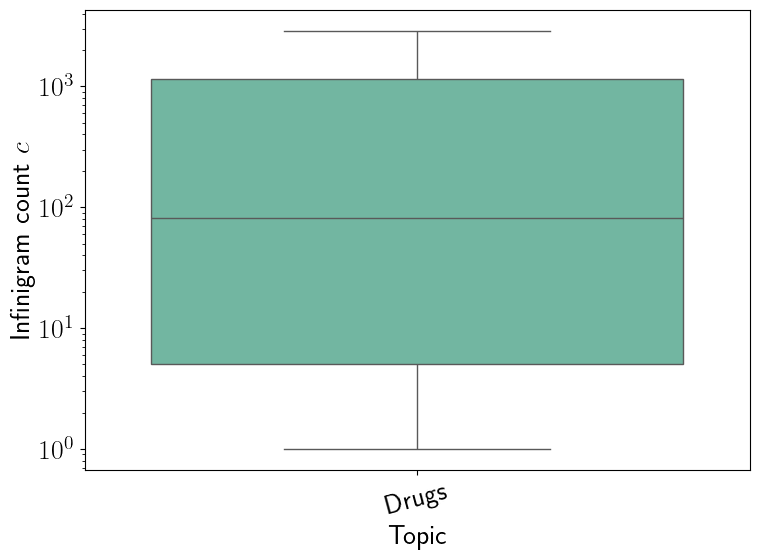

In [91]:
import seaborn as sns

# Create a figure with boxplots for each dataset and deduped combination
plt.figure(figsize=(8, 6))

# Create a boxplot for 'infinigram_count' grouped by 'dataset' and 'deduped'
sns.boxplot(data=df[df['infinigram_count'] > 0], x='dataset', y='infinigram_count', palette='Set2', showfliers=False)

# Add labels and title
plt.xlabel('Topic')
plt.ylabel('Infinigram count $c$')

plt.yscale('log')

# Rotate x-axis labels for better readability
plt.xticks(rotation=15)

# Show the plot
plt.tight_layout()

plt.savefig('boxplot_datasets.png', dpi=300)

plt.show()


In [83]:
comparison_df_melted.groupby('Dataset').agg(['mean', 'std'])



# Generate a LaTeX table from the grouped statistics
latex_table = comparison_df_melted.groupby('Dataset').agg(['mean', 'std']).reset_index().to_latex(
    index=False, 
    float_format="%.2f", 
    caption="Mean and Standard Deviation of Number of Windows per Dataset", 
    label="tab:dataset_stats"
)

# Print the LaTeX table
print(latex_table)

NameError: name 'comparison_df_melted' is not defined

In [60]:
# # Create a DataFrame from n_windows_per_dataset for comparison
# comparison_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in n_windows_per_dataset.items()]))

# # Melt the DataFrame for easier plotting
# comparison_df_melted = comparison_df.melt(var_name='Dataset', value_name='Number of Windows')

# # Create a figure to compare datasets
# plt.figure(figsize=(8, 6))

# # Use seaborn to create a boxplot for comparison
# sns.violinplot(data=comparison_df_melted, x='Dataset', y='Number of Windows', palette='Set2')

# plt.ylim([0.5, 5])

# # Add labels and title
# plt.xlabel('Dataset')
# plt.ylabel('Size of the region $L$')

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# # Show the plot
# plt.tight_layout()

# plt.savefig('violinplots_size.png', dpi=300)

# plt.show()

In [61]:
# Filter the DataFrame for rows where infinigram_count is between 1 and 3
filtered_df = df[(df['infinigram_count'] >= 1) & (df['infinigram_count'] <= 3)]

# Sample a random row
random_sample = filtered_df.sample(n=1)

# Extract the text
sampled_text = random_sample.iloc[0]['text']

# Display the sampled text
print("Sampled Text:", sampled_text)

Sampled Text:  for studying the effects of a


In [62]:
# Randomly sample one row from each category
sampled_rows = df.groupby('category').apply(lambda x: x.sample(3)).reset_index(drop=True)

# Add a row for "high perplexity" by sampling 3 rows with perplexity above 12
high_perplexity_rows = df[df['perplexity'] > 10].sample(3)
high_perplexity_rows['category'] = 'High perplexity'

# Append the high perplexity rows to the sampled rows
sampled_rows = pd.concat([sampled_rows, high_perplexity_rows], ignore_index=True)

# Display the sampled rows
print(sampled_rows[['text', 'category']].to_latex(index=False))

/tmp/ipykernel_31920/1767818497.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



ValueError: a must be greater than 0 unless no samples are taken

In [63]:
dataset_df.columns

Index(['file', 'experiment_name', 'dataset', 'prompt_id', 'generation_id',
       'region_id', 'deduped', 'infinigram_count', 'standalone_perplexity',
       'perplexity', 'min_perplexity', 'max_perplexity', 'text', 'temperature',
       'model_name', 'in_prompt', 'is_contiguous', 'start_index', 'end_index',
       'infinigram_approx', 'infinigram_count_adj', 'category'],
      dtype='object')

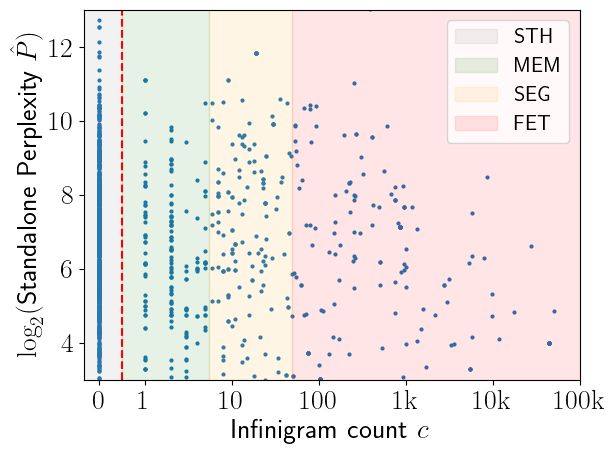

{'Synthetic coherence': 0.6220059880239521,
 'Frequently encountered text': 0.1377245508982036,
 'Segmental replication': 0.12874251497005987,
 'Memorization': 0.11152694610778444}

In [64]:
# Filter the DataFrame for the "cyber" dataset

dataset = 'Cryptography'
dataset_df = df[df['dataset'] == dataset]

# Create a scatter plot
fig = plt.scatter(dataset_df['infinigram_count_adj'], np.log(dataset_df['standalone_perplexity']), s=4)
plt.axvline(x=.55, color='r', linestyle='--')

# Color region where count > 1000
plt.fill_betweenx([0, 15], 0.1, 0.55, color='gray', alpha=0.1, label='STH')
plt.fill_betweenx([0, 15], 0.55, 5.5, color='green', alpha=0.1, label='MEM')
plt.fill_betweenx([0, 15], 5.5, 50, color='orange', alpha=0.1, label='SEG')
plt.fill_betweenx([0, 15], 50, 10000000000, color='red', alpha=0.1, label='FET')

plt.legend(fontsize=15)

# Update x-axis ticks

plt.xlabel('Infinigram count $c$')
plt.ylabel(r'$\log_2($Standalone Perplexity $\hat{P})$')

plt.xlim(0.2, 1e5)
plt.ylim(3, 13)

plt.xscale('log')
plt.xticks([0.3, 1, 10, 100, 1000, 10000, 100000], ['$0$', '$1$', '$10$', '$100$', r'$1\textrm{k}$', r'$10\textrm{k}$', r'$100\textrm{k}$'])

plt.savefig(f'{dataset}_scatter.png', dpi=300, bbox_inches='tight')

plt.show()

# Calculate the counts for each category
region_counts = dataset_df['category'].value_counts(normalize=True).to_dict()

# Display the counts
region_counts

In [92]:
result = df.groupby('dataset').agg(
    avg_perplexity=('perplexity', 'mean'),
    total_low_perplexity_regions=('perplexity', 'count'),
    non_zero_counts=('infinigram_count', lambda x: (x > 0).sum()),
    in_prompt_ratio=('in_prompt', lambda x: f"{(100 * x.sum() / len(x)):.2g}\%")
).reset_index()  # Reset index to make 'dataset' a column
n_windows_stats = {k: {'avg': np.mean(v), 'std': np.std(v)} for k, v in n_windows_per_dataset.items()}

# Add n_windows_avg and n_windows_std columns to the result DataFrame
result['n_windows_avg'] = result['dataset'].map(lambda x: n_windows_stats.get(x, {}).get('avg', np.nan))
result['n_windows_std'] = result['dataset'].map(lambda x: n_windows_stats.get(x, {}).get('std', np.nan))

# Calculate percentage of non-zero counts
result['non_zero_percent'] = (result['non_zero_counts'] / result['total_low_perplexity_regions'] * 100).map('{:.2g}\\%'.format)

# Reorder columns
result = result[['dataset', 'total_low_perplexity_regions', 'non_zero_counts', 'non_zero_percent', 'in_prompt_ratio']]

# Add a row for all datasets combined
all_datasets_row = {
    'dataset': 'Total',
    'total_low_perplexity_regions': result['total_low_perplexity_regions'].sum(),
    'non_zero_counts': result['non_zero_counts'].sum(),
    'non_zero_percent': f"{(result['non_zero_counts'].sum() / result['total_low_perplexity_regions'].sum() * 100):.2g}\\%",
    'in_prompt_ratio': f"{(result['in_prompt_ratio'].str.rstrip('\\%').astype(float).mean()):.2g}\\%",
}

# Append the row to the result DataFrame
result = pd.concat([result, pd.DataFrame([all_datasets_row])], ignore_index=True)

# Set float format to 2 significant digits
print(result.to_latex(index=False, float_format="%.2g"))

\begin{tabular}{lrrll}
\toprule
dataset & total_low_perplexity_regions & non_zero_counts & non_zero_percent & in_prompt_ratio \\
\midrule
Drugs & 2029 & 897 & 44\% & 46\% \\
Total & 2029 & 897 & 44\% & 46\% \\
\bottomrule
\end{tabular}



<>:5: SyntaxWarning:

invalid escape sequence '\%'

<>:5: SyntaxWarning:

invalid escape sequence '\%'

/tmp/ipykernel_31920/1932409672.py:5: SyntaxWarning:

invalid escape sequence '\%'



In [66]:
# Filter examples where in_prompt is True
in_prompt_true_examples = df[df['in_prompt'] == True].sample(n=5)

# Filter examples where in_prompt is False
in_prompt_false_examples = df[df['in_prompt'] == False].sample(n=5)

# Display the examples
print("Examples where in_prompt is True:")
print(in_prompt_true_examples[['prompt_id', 'generation_id', 'dataset', 'text']])

print("\nExamples where in_prompt is False:")
print(in_prompt_false_examples[['prompt_id', 'generation_id', 'dataset', 'text']])

Examples where in_prompt is True:
     prompt_id generation_id       dataset  \
439      P0034     P0034_G03      Genetics   
2557     P0017     P0017_G03  Cryptography   
1865     P0023     P0023_G01  Cryptography   
46       P0038     P0038_G00      Genetics   
1064     P0030     P0030_G02      Genetics   

                                         text  
439                it occurs in human beings.  
2557   digital certificates which are used to  
1865     information apart from the fact that  
46     interplay of such genetic factors with  
1064               genes, behavior, the brain  

Examples where in_prompt is False:
     prompt_id generation_id          dataset                     text
2900     P0013     P0013_G03            Drugs               V\n\nW\n\n
2174     P0009     P0009_G02     Cryptography   a block cipher. DES is
4022     P0029     P0029_G03  Nuclear physics   decay with a proton (β
4410     P0015     P0015_G02  Nuclear physics        \n\nwhere  is the
1970     P

In [93]:
# Filter the DataFrame for rows where infinigram_count > 0
filtered_df = df[df['infinigram_count'] > 0]

# Group by dataset and calculate the ratio of in_prompt=True
in_prompt_ratio = filtered_df.groupby('dataset')['in_prompt'].mean()

# Print the results
print(in_prompt_ratio)

dataset
Drugs    0.383501
Name: in_prompt, dtype: float64


In [94]:
result = df.groupby(['category', 'dataset']).agg(
    total_low_perplexity_regions=('perplexity', 'count')).reset_index('category')

# Reset index to make dataset a column
result = result.reset_index()
result = result.pivot(index='dataset', columns='category', values='total_low_perplexity_regions')
result.columns.name = None
result = result.div(result.sum(axis=1), axis=0) * 100
result = result[['Synthetic coherence','Memorization','Segmental replication','Frequently encountered text',]].map('{:.2g}\\%'.format)

# Set float format to 2 significant digits
print(result.to_latex(index=True, float_format="%.2g"))

\begin{tabular}{lllll}
\toprule
 & Synthetic coherence & Memorization & Segmental replication & Frequently encountered text \\
dataset &  &  &  &  \\
\midrule
Drugs & 56\% & 9.8\% & 11\% & 24\% \\
\bottomrule
\end{tabular}



In [84]:
result = df_temperature.groupby(['category', 'temperature']).agg(
    total_low_perplexity_regions=('perplexity', 'count')).reset_index('category')

# Reset index to make dataset a column
result = result.reset_index()
result = result.pivot(index='temperature', columns='category', values='total_low_perplexity_regions')
result.columns.name = None
result = result.div(result.sum(axis=1), axis=0) * 100
result.reset_index(inplace=True)

# Set float format to 2 significant digits
print(result.to_latex(index=False, float_format="%.2g"))

\begin{tabular}{rrrrr}
\toprule
temperature & Frequently encountered text & Memorization & Segmental replication & Synthetic coherence \\
\midrule
0.2 & 11 & 13 & 13 & 63 \\
0.3 & 11 & 13 & 13 & 63 \\
0.4 & 9.8 & 13 & 13 & 64 \\
0.5 & 10 & 12 & 12 & 66 \\
0.6 & 10 & 11 & 13 & 65 \\
0.7 & 14 & 11 & 13 & 62 \\
\bottomrule
\end{tabular}



In [70]:
df_temperature[df_temperature['temperature'] == 0.7]['in_prompt'].mean()
df[df['file'] == 'jsons/perplexity_results_crispr_2_with_counts.json']['in_prompt'].mean()

nan

In [88]:
result = df_temperature.groupby('temperature').agg(
    avg_perplexity=('standalone_perplexity', lambda x: f"{np.log(x.mean()):.2g}"),
    total_low_perplexity_regions=('perplexity', 'count'),
    non_zero_counts=('infinigram_count', lambda x: (x > 0).sum()),
    in_prompt_ratio=('in_prompt', lambda x: f"{(100 * x.sum() / len(x)):.0f}\%")
)

# Calculate percentage of non-zero counts
result['non_zero_percent'] = (result['non_zero_counts'] / result['total_low_perplexity_regions'] * 100).map('{:.2g}\\%'.format)

# Reorder columns
result= result.reset_index()
result = result[['temperature', 'total_low_perplexity_regions', 'non_zero_counts', 'non_zero_percent', 'in_prompt_ratio', 'avg_perplexity']]

# Set float format to 2 significant digits
print(result.to_latex(index=False, float_format="%.2g"))

\begin{tabular}{rrrlll}
\toprule
temperature & total_low_perplexity_regions & non_zero_counts & non_zero_percent & in_prompt_ratio & avg_perplexity \\
\midrule
0.2 & 9250 & 3414 & 37\% & 11\% & 8.8 \\
0.3 & 7059 & 2611 & 37\% & 14\% & 8.7 \\
0.4 & 5111 & 1853 & 36\% & 19\% & 8.9 \\
0.5 & 3217 & 1108 & 34\% & 20\% & 9 \\
0.6 & 2107 & 739 & 35\% & 22\% & 8.9 \\
0.7 & 1336 & 505 & 38\% & 32\% & 8.7 \\
\bottomrule
\end{tabular}



<>:5: SyntaxWarning:

invalid escape sequence '\%'

<>:5: SyntaxWarning:

invalid escape sequence '\%'

/tmp/ipykernel_31920/3529644491.py:5: SyntaxWarning:

invalid escape sequence '\%'



In [72]:
dataset_df[dataset_df['text'] == '-in-the-middle']['infinigram_count'].sum()

395028

In [75]:
import plotly.express as px

# Filter the DataFrame for the "cyber" dataset

# Create a scatter plot
fig = px.scatter(df[df['dataset'] == 'Drugs'], x='infinigram_count_adj', y='standalone_perplexity', color='deduped',
                 title='Scatter Plot of Infinigram Count vs Perplexity for All Dataset',
                 labels={'infinigram_count': 'Infinigram Count', 'perplexity': 'Perplexity'},
                 hover_data=['text'])

fig.update_xaxes(type='log')
fig.update_yaxes(type='log')

fig.update_layout({'width': 1200, 'height': 800})

# Show the plot
fig.show()

defaultdict(list,
            {'jsons/perplexity_results_drugs_nd_with_counts.json': [1,
              1,
              1,
              1,
              1,
              1,
              2,
              3,
              2,
              4,
              1,
              2,
              9,
              2,
              2,
              2,
              1,
              1,
              1,
              2,
              3,
              2,
              1,
              1,
              1,
              4,
              1,
              1,
              2,
              1,
              1,
              1,
              1,
              1,
              1,
              4,
              2,
              5,
              19,
              4,
              1,
              1,
              1,
              2,
              2,
              3,
              2,
              3,
              70,
              1,
              4,
              7,
              1,
              3,
        

In [12]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import glob

# Initialize an empty list to store data from all files
all_data = []
json_file_path = '../*math*_with_counts*'  # Replace with actual path

# Function to load JSON files and extract data
for file in glob.glob(json_file_path):
    print(f"Processing: {file}")
    # Extract metadata from filename
    filename_parts = file.split('_')
    dataset = filename_parts[2]  # Assuming dataset is consistently at index 2
    deduped = 'deduped' in file
    
    if 'deduped' in file or 'T0' in file:
        continue
    
    # Load the JSON file
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Extract data from each file while preserving order
    file_data = []
    for el in data:
        # Keep list of items in each element to preserve original order
        element_items = []
        for item in el['low_perplexity_windows']:
            # Create a dictionary for each data point
            data_point = {
                'dataset': dataset,
                'deduped': deduped,
                'infinigram_count': item.get('infinigram_count', 0),
                'perplexity': item.get('window_avg_perplexity', 1),
                'text': item['window_text'],
                'tokens': item.get('infinigram_tokens', [])
            }
            element_items.append(data_point)
        
        # Add contiguity information
        for i in range(len(element_items) - 1):
            # We'll mark items as contiguous in the next step
            # Also store the index of the next item for easy reference
            element_items[i]['next_index'] = i + 1
        
        # Add the last item without a next_index
        if element_items:
            element_items[-1]['next_index'] = -1
        
        # Add all items from this element to our collection
        file_data.extend(element_items)
    
    # Now determine contiguity between items in this file
    for i in range(len(file_data) - 1):
        # Skip if this is the last item in an element
        if file_data[i]['next_index'] == -1:
            file_data[i]['is_contiguous'] = False
            continue
        
        # Check if there's substring overlap between current and next item
        current_text = file_data[i]['text']
        next_text = file_data[i+1]['text']
        
        # Function to check for substring overlap
        def has_substring_overlap(text1, text2, min_overlap=3):
            # Try different overlap lengths
            for overlap_len in range(min(len(text1), len(text2)), min_overlap-1, -1):
                # Check if end of text1 matches start of text2
                if text1[-overlap_len:] == text2[:overlap_len]:
                    return True
            return False
        
        # Alternatively, check token overlap
        current_tokens = set(file_data[i]['tokens'])
        next_tokens = set(file_data[i+1]['tokens'])
        token_overlap = len(current_tokens.intersection(next_tokens))
        
        # Mark as contiguous if there's significant substring or token overlap
        is_contiguous = has_substring_overlap(current_text, next_text, 3) or token_overlap >= 2
        file_data[i]['is_contiguous'] = is_contiguous
    
    # Add last item as not contiguous
    if file_data:
        file_data[-1]['is_contiguous'] = False
    
    all_data.extend(file_data)
    print(f"Processed {len(file_data)} items from {file}")

df = pd.DataFrame(all_data)

df['infinigram_count_adj'] = df['infinigram_count'].copy()
df.loc[df['infinigram_count_adj'] == 0, 'infinigram_count_adj'] = 0.3

conditions = [
    (df['infinigram_count_adj'] > 100),
    ((df['infinigram_count_adj'] >= 0.1) & (df['infinigram_count_adj'] <= 5) & (df['perplexity'] >= 10)),
    ((df['infinigram_count_adj'] >= 0.55) & (df['infinigram_count_adj'] <= 5) & (df['perplexity'] >= 0) & (df['perplexity'] <= 10)),
    ((df['infinigram_count_adj'] >= 5) & (df['infinigram_count_adj'] <= 100) & (df['perplexity'] >= 0)),
    ((df['infinigram_count_adj'] >= 0.1) & (df['infinigram_count_adj'] <= 0.55) & (df['perplexity'] >= 0) & (df['perplexity'] <= 10))
]

categories = [
    "Frequently encountered text",
    "Degeneration",
    "Memorization",
    "Segmental replication",
    "Synthetic coherence"
]

# Create a pandas DataFrame from the collected data
df['category'] = np.select(conditions, categories, default='Other')

# Display information about the combined dataset
print("\nCombined Dataset Summary:")
print(f"Total entries: {len(df)}")
print(f"Unique datasets: {df['dataset'].unique()}")


Processing: ../perplexity_results_math_nd_with_counts.json
Processed 1618 items from ../perplexity_results_math_nd_with_counts.json

Combined Dataset Summary:
Total entries: 1618
Unique datasets: ['math']


/tmp/ipykernel_17719/1047426465.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['infinigram_count_adj'] == 0, 'infinigram_count_adj'] = 0.3


In [13]:
print(df.head())

  dataset  deduped  infinigram_count  perplexity  \
0    math    False                 0    7.458956   
1    math    False                 0    6.573632   
2    math    False                 0    6.533880   
3    math    False                12    6.573144   
4    math    False                 0    5.632308   

                                          text  \
0   product of all positive integers less than   
1        of all positive integers less than or   
2     all positive integers less than or equal   
3      positive integers less than or equal to   
4             integers less than or equal to n   

                                              tokens  next_index  \
0  [product, ▁of, ▁all, ▁positive, ▁integers, ▁le...           1   
1  [of, ▁all, ▁positive, ▁integers, ▁less, ▁than,...           2   
2  [all, ▁positive, ▁integers, ▁less, ▁than, ▁or,...           3   
3  [pos, itive, ▁integers, ▁less, ▁than, ▁or, ▁eq...           4   
4   [inte, gers, ▁less, ▁than, ▁or, ▁equal, ▁t

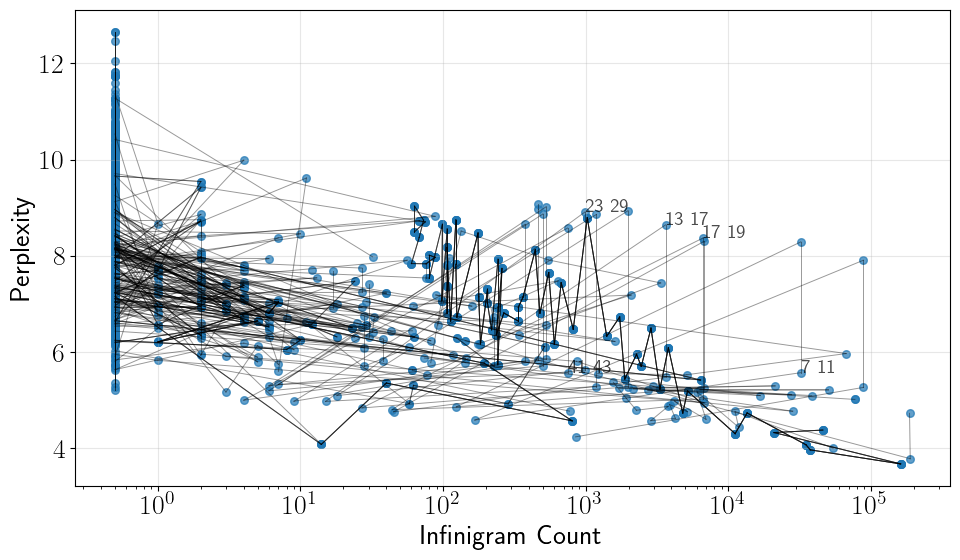

In [30]:
df_interest = df[df['dataset'] == 'math']
df_interest = df
# change count from 0 to 0.5 for log scale
df_interest['infinigram_count'] = df_interest['infinigram_count'].replace(0, 0.5)

df_interest.reset_index(drop=True, inplace=True)

# Optional: Create a more detailed visualization focusing on contiguous segments
# Group by dataset and visualize each separately
for dataset_name, group in df_interest.groupby('dataset'):
    plt.figure(figsize=(10, 6))
    
    # Plot all points in this dataset
    plt.scatter(
        group['infinigram_count'], 
        group['perplexity'],
        alpha=0.7,
        label=dataset_name,
        s=30
    )
    plt.xscale('log')
    
    # Add connections between contiguous segments
    connections_count = 0
    for i, row in group.iterrows():
        if row['is_contiguous'] and i < len(df_interest) - 1 and i+1 in group.index:
            # Draw a line between this point and the next
            # if abs(np.log(row['infinigram_count']) - np.log(df_interest.loc[i+1, 'infinigram_count'])) > 0.3:
                # continue
            plt.plot(
                [row['infinigram_count'], df_interest.loc[i+1, 'infinigram_count']], 
                [row['perplexity'], df_interest.loc[i+1, 'perplexity']], 
                'k-',
                alpha=0.4,
                linewidth=0.7
            )
            connections_count += 1
    # Filter points whose text contains only numbers separated by spaces
    numeric_points = group[group['text'].str.match(r'^\s*\d+(\s+\d+)*\s*$')]

    # Randomly sample 10 points from the numeric points
    sampled_numeric_points = numeric_points.sample(n=min(5, len(numeric_points)))

    # Add text tags to the sampled points
    for _, row in sampled_numeric_points.iterrows():
        plt.text(
            row['infinigram_count'], 
            row['perplexity'], 
            row['text'].replace('\n', ' '), 
            fontsize=14, 
            color='black', 
            alpha=0.7
        )
    
    # Set plot labels and title
    plt.xlabel('Infinigram Count')
    plt.ylabel('Perplexity')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'contiguous_segments_{dataset_name}.png', dpi=300)
    plt.show()

In [120]:
df_interest[df_interest['is_contiguous'] == True]

,dataset,deduped,infinigram_count,perplexity,text,tokens,next_index,is_contiguous
3,cyber,False,6.0,8.497604,be used to ensure that messages are,"[▁used, ▁to, ▁ensure, ▁that, ▁messages, ▁are]",1,True
7,cyber,False,34.0,8.119696,receiver uses the same key to dec,"[▁uses, ▁the, ▁same, ▁key, ▁to, ▁dec]",1,True
8,cyber,False,122.0,6.313290,uses the same key to decrypt,"[▁the, ▁same, ▁key, ▁to, ▁dec, rypt]",2,True
9,cyber,False,47.0,8.887592,the same key to decrypt the,"[▁same, ▁key, ▁to, ▁dec, rypt, ▁the]",3,True
10,cyber,False,623.0,8.572116,same key to decrypt the message,"[▁key, ▁to, ▁dec, rypt, ▁the, ▁message]",4,True
...,...,...,...,...,...,...,...,...
6888,crispr,False,27113.0,5.575808,wide association studies (GWAS),"[▁association, ▁studies, ▁(, G, W, AS, )]",1,True
6890,crispr,False,5.0,10.285876,the causal gene or genes.\n,"[▁caus, al, ▁gene, ▁or, ▁gen, es, .]",3,True
6891,crispr,False,501.0,10.134613,causal gene or genes.\n\n,"[▁gene, ▁or, ▁gen, es, .]",4,True
6893,crispr,False,3435.0,5.592325,fruit fly Drosophila melanogaster,"[▁fly, ▁D, ros, oph, ila, ▁mel, an, og, aster]",1,True


[[  0. 271.   2. 198.  43.]
 [  0. 894.  22. 784. 107.]
 [  0. 341.   2. 262.  49.]
 [  0. 676.   6. 562.  84.]
 [  0. 580.   5. 476.  83.]]


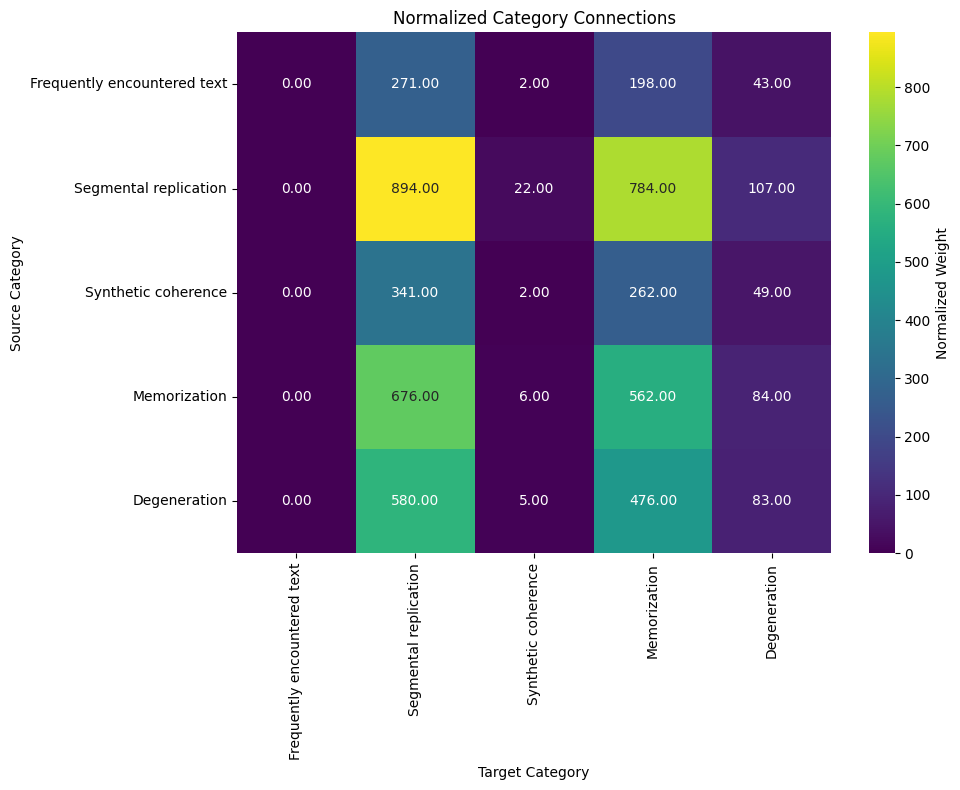

In [26]:
import seaborn as sns

unique_categories = df['category'].unique()

# Initialize variables
num_categories = len(unique_categories)
matrix = np.zeros((num_categories, num_categories))

for i, row in df.iterrows():
    next_idx = row['next_index']
    if next_idx != -1 and next_idx < len(df):
        source_cat = row['category']
        target_cat = df.iloc[next_idx]['category']
        source_idx = category_to_index[source_cat]
        target_idx = category_to_index[target_cat]
        matrix[source_idx, target_idx] += 1 # row['infinigram_count_adj']

matrix_df = pd.DataFrame(matrix, index=unique_categories, columns=unique_categories)

print(matrix)

# Normalize the matrix per row
normalized_matrix = matrix

# Convert the normalized matrix to a DataFrame
normalized_matrix_df = pd.DataFrame(normalized_matrix, index=unique_categories, columns=unique_categories)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_matrix_df, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Normalized Weight'})
plt.title("Normalized Category Connections")
plt.xlabel("Target Category")
plt.ylabel("Source Category")
plt.tight_layout()
plt.show()

/tmp/ipykernel_15912/3073161426.py:78: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



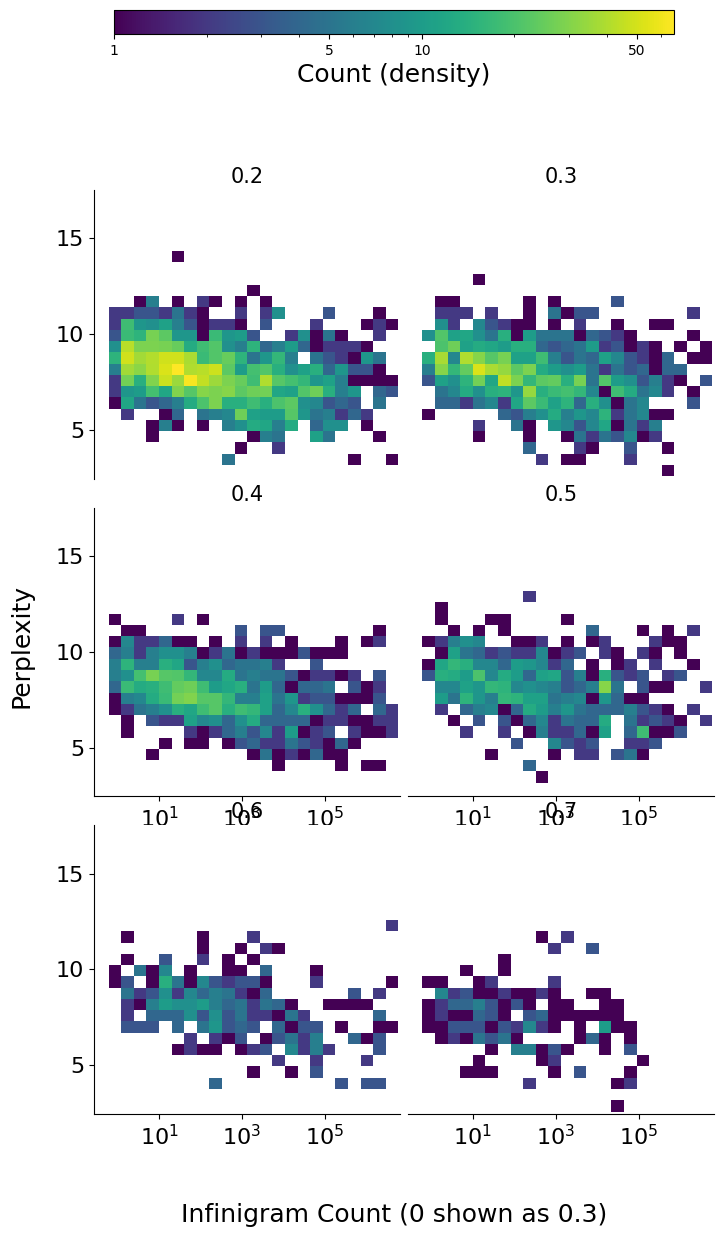

In [31]:

# Get unique datasets
datasets = df_temperature.groupby('temperature')
n_datasets = len(datasets)

# Determine global min and max for consistent scales
perp_min = df['perplexity'].min()
perp_max = df['perplexity'].max()
inf_min = df['infinigram_count_adj'].min()
inf_max = df['infinigram_count_adj'].max()

fig = plt.figure(figsize=(8, 12))
gs = GridSpec(3, 2, figure=fig, wspace=0.025, hspace=0.1)

# Define consistent bins for histograms
x_bins = np.logspace(np.log10(inf_min), np.log10(max(inf_max, 1000)), 25)
y_bins = np.linspace(perp_min, perp_max, 25)

# Define consistent colormap and normalization for all plots
cmap = plt.cm.viridis
norm = colors.LogNorm()  # Use log normalization for the colormap

# Create all plots
for i, (dataset_name, dataset_df) in enumerate(datasets):
    row, col = i // 2, i % 2
    ax = fig.add_subplot(gs[row, col])
    
    # ax.set_facecolor(cmap(0))
    
    # Create 2D histogram
    h, xedges, yedges, img = ax.hist2d(
        dataset_df['infinigram_count'],
        dataset_df['perplexity'],
        bins=[x_bins, y_bins],
        cmap=cmap,
        norm=norm,
        cmin=.1
    )
    
    # Configure axis scales
    ax.set_xscale('log')
    
    # Set consistent axis limits
    ax.set_xlim(inf_min * 0.9, inf_max * 1.1)
    ax.set_ylim(perp_min * 0.95, perp_max * 1.05)
    
    # Make only bottom x-axis and left y-axis visible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if row == 0:
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.set_ticks([])
    if col == 1:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks([])
        
    # Set axis label font sizes
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    # Add subtle title with dataset name
    ax.set_title(dataset_name, fontsize=15, color='black', pad=5)

# Add a colorbar at the top that applies to all subplots
cbar_ax = fig.add_axes([0.15, 1.01, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Count (density)', fontsize=18)
cbar.set_ticks([1, 5, 10, 50])
cbar.set_ticklabels(['1', '5', '10', '50'])

# Add centered x-axis label for both columns
fig.text(0.5, 0.02, 'Infinigram Count (0 shown as 0.3)', ha='center', fontsize=18)

# Add centered y-axis label for both rows
fig.text(0.02, 0.5, 'Perplexity', va='center', rotation='vertical', fontsize=18)

# Adjust layout for better spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.9])  # [left, bottom, right, top]

plt.savefig('../images/scatter_subplots.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_15912/3405773284.py:84: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



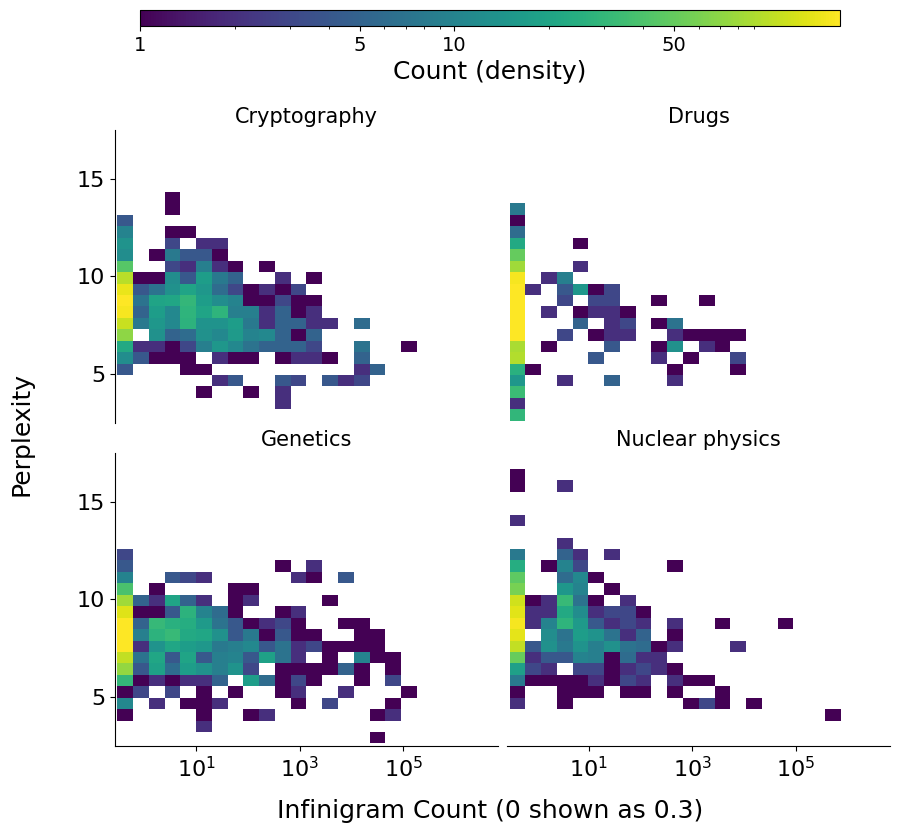

In [47]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

# Get unique datasets
datasets = df.groupby('dataset')
n_datasets = len(datasets)

# Determine global min and max for consistent scales
perp_min = df['perplexity'].min()
perp_max = df['perplexity'].max()
inf_min = df['infinigram_count_adj'].min()
inf_max = df['infinigram_count_adj'].max()

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2, figure=fig, wspace=0.025, hspace=0.1)

# Define consistent bins for histograms
x_bins = np.logspace(np.log10(inf_min), np.log10(max(inf_max, 1000)), 25)
y_bins = np.linspace(perp_min, perp_max, 25)

# Define consistent colormap and normalization for all plots
cmap = plt.cm.viridis
norm = colors.LogNorm()  # Use log normalization for the colormap

# Create all plots
for i, (dataset_name, dataset_df) in enumerate(datasets):
    row, col = i // 2, i % 2
    ax = fig.add_subplot(gs[row, col])
    
    # ax.set_facecolor(cmap(0))
    
    # Create 2D histogram
    h, xedges, yedges, img = ax.hist2d(
        dataset_df['infinigram_count_adj'],
        dataset_df['perplexity'],
        bins=[x_bins, y_bins],
        cmap=cmap,
        norm=norm,
        cmin=.1
    )
    
    # Configure axis scales
    ax.set_xscale('log')
    
    # Set consistent axis limits
    ax.set_xlim(inf_min * 0.9, inf_max * 1.1)
    ax.set_ylim(perp_min * 0.95, perp_max * 1.05)
    
    # Make only bottom x-axis and left y-axis visible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if row == 0:
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.set_ticks([])
    if col == 1:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks([])
        
    # Set axis label font sizes
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    # Add subtle title with dataset name
    ax.set_title(dataset_name, fontsize=15, color='black', pad=5)

# Add a colorbar at the top that applies to all subplots
cbar_ax = fig.add_axes([0.15, 1.01, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Count (density)', fontsize=18)
cbar.set_ticks([1, 5, 10, 50])
cbar.set_ticklabels(['1', '5', '10', '50'])

# Add centered x-axis label for both columns
fig.text(0.5, 0.02, 'Infinigram Count (0 shown as 0.3)', ha='center', fontsize=18)

# Add centered y-axis label for both rows
fig.text(0.02, 0.5, 'Perplexity', va='center', rotation='vertical', fontsize=18)

# Adjust layout for better spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.9])  # [left, bottom, right, top]

plt.savefig('../images/scatter_subplots.png', dpi=300, bbox_inches='tight')
plt.show()